# DeFactify – the Masterpiece

## Introduction ℹ️

Our daily lives are heavily influenced by digital media, which has led to the rapid spread of misinformation like never before. The rise of fake news presents significant challenges to public trust, informed decision-making and even democratic processes. To address this issue, this project "DeFactify" aims to provide a data-driven solution that automatically detects and classifies news articles as either real or fake.

DeFactify is a machine learning project designed to identify deceptive news using linguistic features, based on news articles recently collected from various sources. By analyzing article titles and body text, the system learns to differentiate between trustworthy and suspicious content.


## Libraries 📚

First, let's begin by importing the libraries and checking their versions.

In [1]:
import nltk
import numpy
import joblib
import pandas
import sklearn
import seaborn

import matplotlib.pyplot as plt

from wordcloud import WordCloud

from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize

from sklearn.svm import SVC
from sklearn import preprocessing
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.ensemble import AdaBoostClassifier, StackingClassifier, RandomForestClassifier

print("Library versions:")
print("- nltk:", nltk.__version__)              # 3.9.1
print("- numpy:", numpy.__version__)            # 2.1.3
print("- joblib:", joblib.__version__)          # 1.4.2
print("- pandas:", pandas.__version__)          # 2.2.3
print("- sklearn:", sklearn.__version__)        # 1.6.1
print("- seaborn:", seaborn.__version__)        # 0.13.2

Library versions:
- nltk: 3.9.1
- numpy: 2.1.3
- joblib: 1.4.2
- pandas: 2.2.3
- sklearn: 1.6.1
- seaborn: 0.13.2


## Data provisioning 📦

As I stated in the introduction, I scraped the dataset myself to provide sufficient information for training the models. One of the first problems I faced at the beginning was an old dataset filled with unreliable data, which I could not confirm as generated or authentic. 

To combat the unreliable information, I needed to gather the dataset and specify the requirements for the data columns:
- Title 
- URL
- Source 
- Journalist(s) (if available)
- Published Date
- Content/Body text
- Category (Politics, Sports, etc.)
- Label: either "Fake" (0) or "Real" (1).

### Real News ✅

The next step is to load all the scraped CSV files, containing two types of articles - "Fake" and "Real". 

The first authentic news will come from the <a href="https://www.bbc.com">BBC</a> website, as they were among the first sources I collected. I gathered 36 to 40 news stories each day, as indicated by the file names. I was unable to find pagination on their homepage, as all their recent content is presented there. This is why I have six different files; I had to collect new data each day instead of gathering all approximately 200 stories at once.

**BBC (British Broadcasting Corporation) 🌐** 
- Founded in 1922, the BBC is the world’s oldest national broadcaster and one of the most respected media organizations globally. It operates under a royal charter in the UK and is funded primarily by the public television license fee, which supports its editorial independence. The BBC is known for its rigorous editorial standards, in-depth investigative journalism and commitment to impartiality. It covers a wide spectrum of news topics from global politics to science and technology. Various media bias tracking platforms - including Media Bias/Fact Check and Ad Fontes Media - consistently rate the BBC as center-aligned, factual and minimally biased. Its reputation for reliability made it a natural choice for training the “real news” component of DeFactify.

In [30]:
bbc1 = pandas.read_csv('scraper/dataset/bbc_23.03.25_real.csv')
bbc1.shape

(36, 8)

In [31]:
bbc2 = pandas.read_csv('scraper/dataset/bbc_24.03.25_real.csv')
bbc2.shape

(38, 8)

In [32]:
bbc3 = pandas.read_csv('scraper/dataset/bbc_27.03.25_real.csv')
bbc3.shape

(38, 8)

In [33]:
bbc4 = pandas.read_csv('scraper/dataset/bbc_31.03.25_real.csv')
bbc4.shape

(38, 8)

In [34]:
bbc5 = pandas.read_csv('scraper/dataset/bbc_06.04.25_real.csv')
bbc5.shape

(41, 8)

In [35]:
bbc6 = pandas.read_csv('scraper/dataset/bbc_07.04.25_real.csv')
bbc6.shape

(40, 8)

This concludes my summary of the BBC files. In addition, I utilized two other websites: <a href="https://apnews.com/">AP News</a> and <a href="https://techcrunch.com/">TechCrunch</a>.

**AP News (The Associated Press) ♦️**
- The Associated Press (AP) is a U.S. - based not-for-profit news agency founded in 1846. It is owned by its contributing newspapers, radio and television stations, all of which contribute stories to the AP and use material written by its staff journalists. The AP is renowned for its fast, accurate and unbiased news coverage across the globe. Its writing is widely syndicated and used as a gold standard in journalism training. The AP has won dozens of Pulitzer Prizes and maintains a strict code of ethics, making it an essential benchmark for factual, politically neutral reporting. It plays a critical role in ensuring the model does not mistake honest journalism for manipulated content.

**TechCrunch 🤖**
- TechCrunch, founded in 2005, is an American online publisher focusing on the tech industry - particularly startups, venture capital, software and emerging technologies. Acquired by Yahoo (and later Verizon Media), TechCrunch is respected in the tech community for its specialized, forward-looking content and early coverage of startups that later become major industry players. While it does not have the same general-news scope as BBC or AP, it offers domain-specific accuracy in the rapidly evolving technology sector. Given a comparative shortage of technology-focused articles in the original dataset, TechCrunch was added to provide balance and relevance in the "Technology" category.

In [36]:
ap = pandas.read_csv('scraper/dataset/apnews_real.csv', encoding='latin1')
ap.shape

(240, 8)

In [37]:
tech = pandas.read_csv('scraper/dataset/techcrunch_real.csv')
tech.shape

(135, 8)

I tried to include news from <a href="https://www.nytimes.com/">The New York Times</a>, <a href="https://www.washingtonpost.com/">The Washington Post</a> and <a href="https://www.bloomberg.com/europe">Bloomberg</a>. Unfortunately, their articles are behind a paywall, which prevents me from accessing and including them. Additionally, I was denied access to <a href="https://www.reuters.com/">Reuters</a> due to restrictions on scraping data from their website.

### Fake News ❌
The websites I scraped for "fake" news include: <a href="https://theonion.com/">The Onion</a>, <a href="https://spacexmania.com">SpaceXMania</a>, <a href="https://thepeoplesvoice.tv">The People's Voice</a> and <a href="https://www.theinteldrop.org">The Intel Drop</a>. Most websites spreading fake news have been flagged or removed, so my sources for recent news are somewhat limited.

Here is a brief overview of each source I used:

**The Onion 🧅**
- The Onion is a well-known American satirical news outlet founded in 1988. It publishes humorous and exaggerated stories that parody real-world events and media narratives. Although its content is entirely fictional, it is clearly labeled as satire and is not intended to mislead. The Onion serves as a baseline for detecting intentionally fake yet transparent content that mimics news format.

**SpaceXMania 🚀**
- SpaceXMania is a website that began as a parody and pop culture site but has since blurred the line between satire and misinformation. According to The New York Times, many of its stories are generated by AI tools like ChatGPT and often lack clear satire disclaimers. Investigations by the Australian Associated Press and academic researchers suggest that the site intentionally labels AI-generated clickbait and fabricated content as “satire” to avoid accountability, making it a notable example of modern misinformation strategies.

**The People's Voice 🔊** 
- This website is a prolific disinformation source known for publishing conspiracy theories, health misinformation and politically charged fake stories. In a 2017 analysis by BuzzFeed News, it ranked as the second-largest fake news site on Facebook based on engagement. It frequently spreads hoaxes and false claims without evidence and has been flagged by fact-checkers across multiple platforms.

**The Intel Drop 💧**
- The Intel Drop is widely regarded as a Russian disinformation platform. It has been linked to the dissemination of anti-Western propaganda, conspiracy theories and content aligned with Russian geopolitical interests. Its articles are often presented in a pseudo-journalistic tone, making them appear credible at first glance while subtly embedding misleading narratives.

In [38]:
onion = pandas.read_csv('scraper/dataset/the_onion_fake.csv')
onion.shape

(130, 8)

In [39]:
spacexmania = pandas.read_csv('scraper/dataset/spacexmania_fake.csv', encoding='latin1')
spacexmania.shape

(149, 8)

In [40]:
peoples_voice = pandas.read_csv('scraper/dataset/peoples_voice_fake.csv')
peoples_voice.shape

(100, 8)

In [41]:
intel_drop = pandas.read_csv('scraper/dataset/intel_drop_fake.csv', encoding='latin1')
intel_drop.shape

(102, 8)

### Combination of all CSV files 📥
Once all data have been imported, the next step is to combine them into a single dataset for easier analysis.

In [44]:
combined_dataset = pandas.concat([bbc1, bbc2, bbc3, bbc4, bbc5, bbc6, onion, spacexmania, peoples_voice, intel_drop, ap, tech])

In [45]:
print("Combined dataset shape (before cleaning):", combined_dataset.shape)

Combined dataset shape (before cleaning): (1087, 8)


## Sample the data 📃
Let's sample the data to check how it looks so far.

In [46]:
combined_dataset.sample(10)

,Title,URL,Source,Journalist(s),Published Date,Content,Category,Label
38,How does Iran strike âIsraelâ?,https://www.theinteldrop.org/2025/04/09/how-do...,The Intel Drop,Nehme Hamieh,9/4/2025,"Nehme Hamieh April 09, 2025 Washingtonâ In i...",Politics,0
11,The man with a mind-reading chip in his brain ...,https://www.bbc.com/news/articles/cewk49j7j1po,BBC,"Lara Lewington, Liv McMahon, Tom Gerken",23-03-25,Having a chip in your brain that can translate...,Technology,1
239,Universal Epic Universe is the theme park reso...,https://apnews.com/newsletter/ground-game/apri...,AP News,Mike Schneider,19-04-25,"ORLANDO, Fla. (AP) â From Harry Potter to Su...",Economy,1
229,"60,000 Americans to lose their rental assistan...",https://apnews.com/newsletter/ground-game/apri...,AP News,Jesse Bedayn,21-04-25,Moments after Daniris Espinal walked into her ...,Economy,1
33,Cabrera returns to Masters for first time sinc...,https://www.bbc.com/sport/golf/articles/c8rgkd...,BBC,Peter Scrivener,7/4/2025,Cabrera won the 36-hole James Hardie Pro Footb...,Sports,1
5,"Chemical burns, assaults, electric shocks - Ga...",https://www.bbc.com/news/articles/cn7vje365rno,BBC,Alice Cuddy,7/4/2025,Warning: This article contains distressing con...,World News,1
29,Uncovered emails showed how Meta struggled to ...,https://techcrunch.com/2025/04/20/uncovered-em...,TechCrunch,Aisha Malik,20-04-25,With the first week of Meta’santitrust trialbe...,Technology,1
45,Trump Cuts Funding To Gates’ Global Vaccine Al...,https://thepeoplesvoice.tv/trump-cuts-funding-...,The People's Voice,Niamh Harris,2/4/2025,US President Donald Trump’s administration pla...,Politics,0
56,The Nintendo Switch 2 will still cost $450 in ...,https://techcrunch.com/2025/04/18/the-nintendo...,TechCrunch,Amanda Silberling,18-04-25,Nintendo announced on Friday that it will open...,Technology,1
31,Juventus sack boss Motta and replace him with ...,https://www.bbc.com/sport/football/articles/c7...,BBC,NaN,23-03-25,Thiago Motta (left) had spells in charge of Ge...,Sports,1


## Preprocessing 🛠️

Machine learning models learn patterns from the data they are given. If the data contains noise, inconsistencies or errors (e.g. typos, null values, duplicates), the model will likely learn misleading or irrelevant patterns - leading to poor performance and unreliable predictions. To prevent this, it is essential to check all rows that contain missing data. If such rows exist, a decision should be made about whether to remove them.

### Null values 0️⃣ 

In [80]:
combined_dataset.isnull().sum()

Title               0
URL                 0
Source              0
Journalist(s)     268
Published Date     19
Content            39
Category            4
Label               0
dtype: int64

To better understand the missing data, it is helpful to visualize it by a Heatmap.

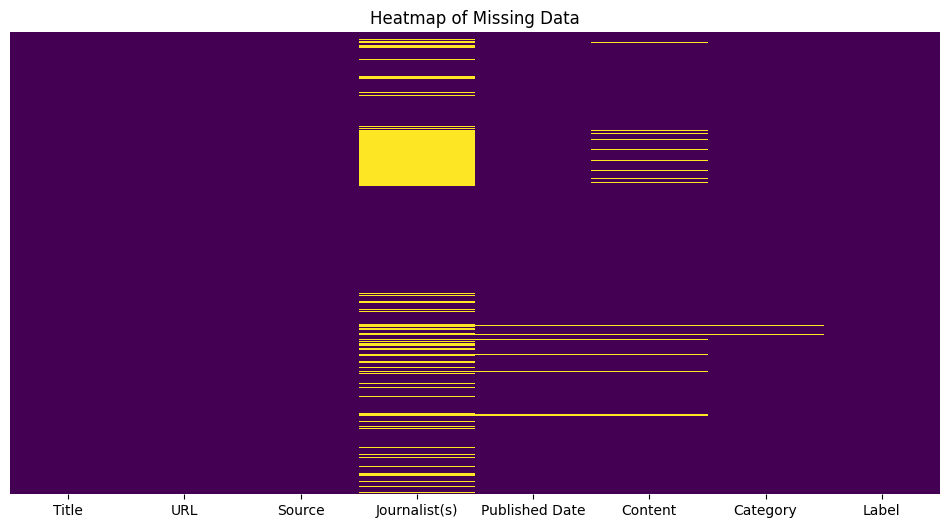

In [81]:
plt.figure(figsize=(12, 6))
seaborn.heatmap(combined_dataset.isnull(), cbar=False, cmap='viridis', yticklabels=False)
plt.title('Heatmap of Missing Data')
plt.show()

Let's compare it not just by the columns, but also by their label.

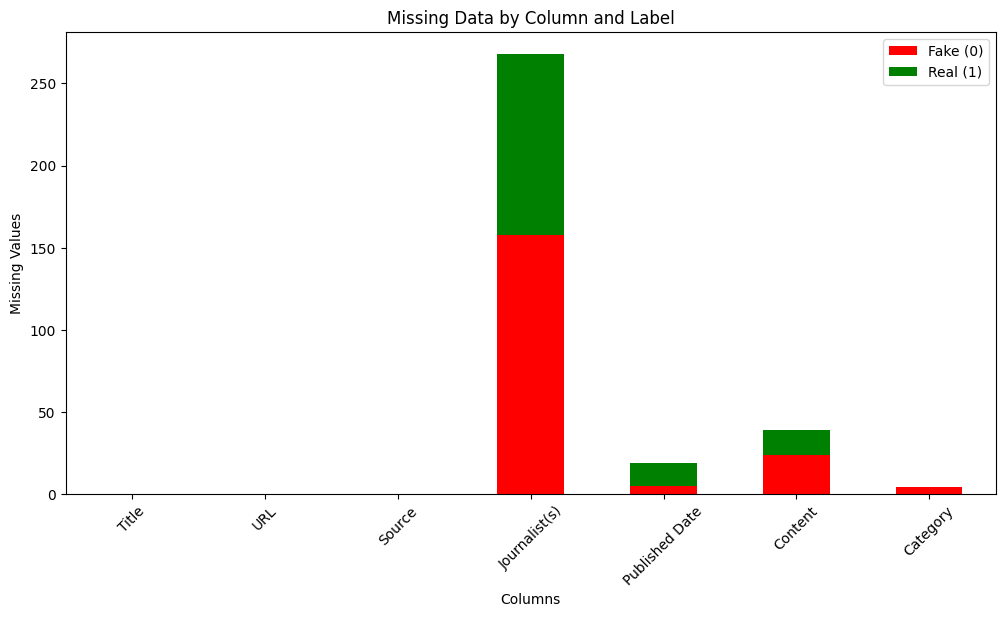

In [82]:
missing_by_label = combined_dataset.drop('Label', axis=1).groupby(combined_dataset['Label']).apply(lambda x: x.isnull().sum())

missing_by_label = missing_by_label.T

missing_by_label.plot(kind='bar', stacked=True, figsize=(12, 6), color=['red', 'green'])
plt.title('Missing Data by Column and Label')
plt.xlabel('Columns')
plt.ylabel('Missing Values')
plt.xticks(rotation=45)
plt.legend(['Fake (0)', 'Real (1)'])
plt.show()

The column with the highest amount of missing data is the "Journalist(s)". In this context, it is acceptable for there to be no listed journalists, as it is common for fake news articles to lack listed authors to avoid accountability and scrutiny. By omitting author names, publishers protect themselves from legal consequences and make it harder to trace the content’s origin. Many fake news sites use AI-generated content or anonymous contributors, which also explains their absence. This anonymity helps obscure the lack of credibility and can be a tactic used in coordinated disinformation campaigns.

Additionally, the absence of a publication date is not a major concern. The only reason I included it as a column is to prove its authenticity and how recent the news is. 

However, the "Content" is a critical element that we will analyze. Therefore, if either the "Content" or the "Category" is missing, we should discard those rows of data. The column with the "Category" may be missing, because the news could have been scraped incorrectly, and I want to ensure the final result and accuracy of the model are not compromised.

In [83]:
cleaned_dataset = combined_dataset.dropna(subset=['Content', 'Category'])

print("Combined dataset shape (after removing nulls):", cleaned_dataset.shape)

Combined dataset shape (after removing nulls): (1048, 8)


### Duplicates 👯‍♂️
Since the data scraping occurred over consecutive days, it is likely that some news titles appear more than once. Identifying and removing duplicate titles is an important step to ensure data quality and prevent redundancy during model training.

In [84]:
duplicate_titles = cleaned_dataset[cleaned_dataset.duplicated(subset=['Title'], keep=False)]

print(f"Number of duplicated titles: {duplicate_titles.shape[0]}")

Number of duplicated titles: 187


Due to the presence of numerous duplicates, we will remove them and retain only the first occurrence.

In [94]:
cleaned_dataset = cleaned_dataset.drop_duplicates(subset=['Title'], keep='first')

print("Combined dataset rows (after removing duplicates):", cleaned_dataset.shape[0])

Combined dataset rows (after removing duplicates): 940


### Format dates 🗓️

I have noticed the inconsistent formatting of dates since the news is sourced from both English and American outlets. I will standardize them, even though it is not essential.

In [95]:
cleaned_dataset['Published Date'] = pandas.to_datetime(cleaned_dataset['Published Date'], errors='coerce', dayfirst=True)
cleaned_dataset['Published Date'] = cleaned_dataset['Published Date'].dt.strftime('%d/%m/%Y')

cleaned_dataset.sample(10)

,Title,URL,Source,Journalist(s),Published Date,Content,Category,Label
37,"Grammy Awards Ban Jennifer Lopezâs Entry, Cl...",https://spacexmania.com/grammy-awards-ban-jenn...,SpaceXMania,Alex Bruno,31/12/2024,"In a surprising and controversial move, the Gr...",Entertainment,0
4,SeaWorld Visitors Delighted By Live Garbage-Pa...,https://theonion.com/seaworld-visitors-delight...,The Onion,NaN,02/04/2025,SAN DIEGO—With the spellbound audience in the ...,Environment,0
31,Juventus sack boss Motta and replace him with ...,https://www.bbc.com/sport/football/articles/c7...,BBC,NaN,23/03/2025,Thiago Motta (left) had spells in charge of Ge...,Sports,1
94,The worldâs âcowboyâ threatens and beats...,https://www.theinteldrop.org/2025/04/06/the-wo...,The Intel Drop,D. Adnan Mansour,06/04/2025,"D. Adnan Mansour* Apr, 06/2025 Beirutâ Since...",Politics,0
35,"In Germanyâs financial capital, traditional ...",https://apnews.com/article/frankfurt-germany-w...,AP News,NaN,12/04/2025,"FRANKFURT, Germany (AP) â Frankfurt has beco...",World News,1
68,Guy Fieri Kicks Tim Walz Out of His Restaurant...,https://spacexmania.com/guy-fieri-kicks-tim-wa...,SpaceXMania,Alex Bruno,17/12/2024,In a surprising and bold move that has garnere...,Entertainment,0
104,Sun Unsure What It Has To Do To Get Humans To ...,https://theonion.com/sun-unsure-what-it-has-to...,The Onion,NaN,14/01/2025,HOUSTON—Coming to terms with its diminished st...,Environment,0
172,A strong solar storm heads to Earth. Hereâs ...,https://apnews.com/newsletter/ground-game/apri...,AP News,Adithi Ramakrishnan,15/04/2025,NEW YORK (AP) â A strong solar storm headed ...,Science,1
61,Health Board Received Slew Of Complaints About...,https://thepeoplesvoice.tv/health-board-receiv...,The People's Voice,Niamh Harris,31/03/2025,Fears continie to be raised over ‘patient safe...,Politics,0
85,NFL Offers $100 Million to Kid Rock and Jason ...,https://spacexmania.com/nfl-offers-100-million...,SpaceXMania,Alex Bruno,13/12/2024,The NFL has made waves with a groundbreaking o...,Sports,0


### Label check 🔎

I am familiar with most of the information in the columns. However, to ensure everything is accurate, I am conducting a final check to confirm that the data contains only 0s and 1s in the "Label" column.

In [78]:
group_info = cleaned_dataset.groupby(["Label"])["Label"].count()
group_info

Label
0    456
1    484
Name: Label, dtype: int64

Overall, the data seems to be evenly distributed between fake and real news.

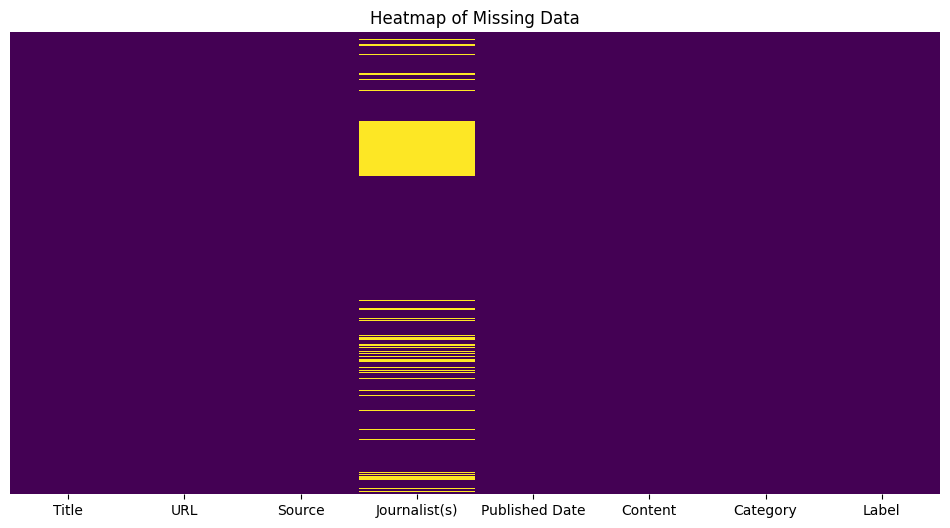

In [96]:
plt.figure(figsize=(12, 6))
seaborn.heatmap(cleaned_dataset.isnull(), cbar=False, cmap='viridis', yticklabels=False)
plt.title('Heatmap of Missing Data')
plt.show()

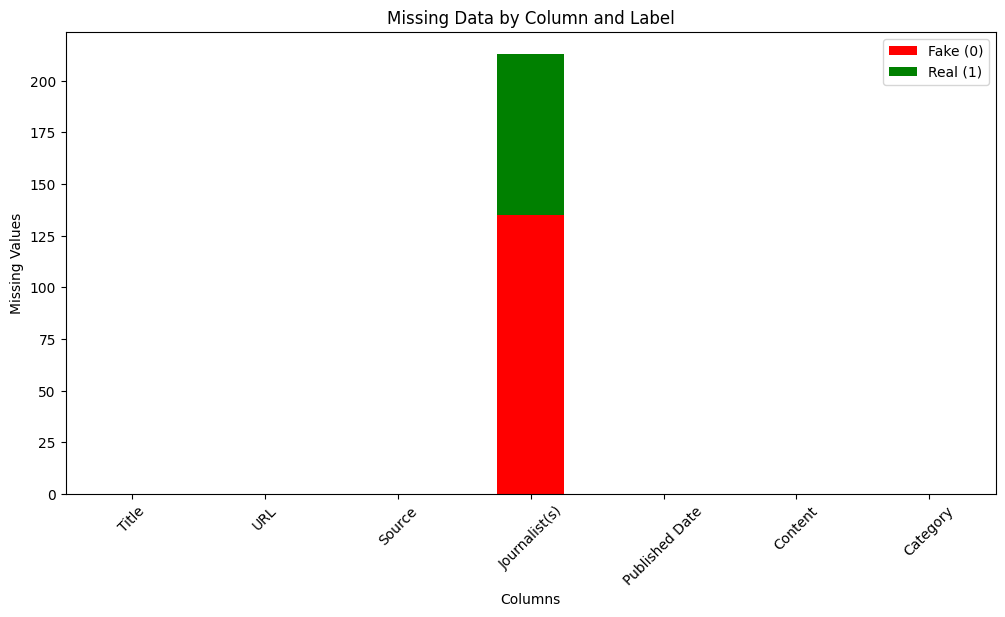

In [97]:
missing_by_label = cleaned_dataset.drop('Label', axis=1).groupby(cleaned_dataset['Label']).apply(lambda x: x.isnull().sum())

missing_by_label = missing_by_label.T

missing_by_label.plot(kind='bar', stacked=True, figsize=(12, 6), color=['red', 'green'])
plt.title('Missing Data by Column and Label')
plt.xlabel('Columns')
plt.ylabel('Missing Values')
plt.xticks(rotation=45)
plt.legend(['Fake (0)', 'Real (1)'])
plt.show()

When we cleaned the "Content" and "Category" columns, we also addressed issues with the published dates. This process removed some news articles that were likely not scraped properly, possibly due to improperly marked HTML tags. 

I believe that having no journalist listed is not a significant issue. In most cases, this implies that no article written by a listed journalist can be considered "fake". However, I will not take this into consideration for my training. I attempted to use it in Iteration 2, but it introduced bias. It assumed that if an article had a journalist, it was "real", and if not, it was "fake". Therefore, I will proceed without it.

This kind of metadata can be misleading, especially when many real articles - particularly news briefs or wire pieces - are published without a byline. Similarly, fake news sites have adapted by occasionally fabricating author names to appear more credible. Since the presence or absence of a listed journalist does not consistently reflect article authenticity, relying on it risks oversimplifying the problem and skewing the model. My focus will remain on the actual content and title of the articles, which offers a more reliable and nuanced foundation for classification.

In [198]:
print("The final dataset shape:", cleaned_dataset.shape)

The final dataset shape: (940, 8)


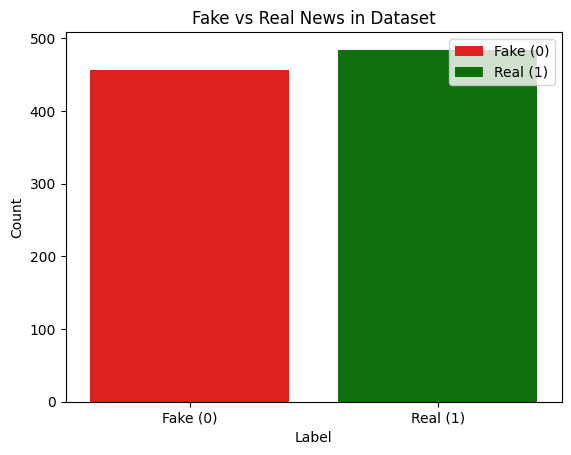

In [98]:
plt.figure()
seaborn.countplot(
    data=cleaned_dataset,
    x='Label',
    hue='Label', 
    palette={0: 'red', 1: 'green'}
)
plt.title('Fake vs Real News in Dataset')
plt.xlabel('Label')
plt.ylabel('Count')
plt.legend(['Fake (0)', 'Real (1)'])
plt.xticks(ticks=[0, 1], labels=['Fake (0)', 'Real (1)'])
plt.show()

The chart above shows the distribution of "Fake" and "Real" news articles in the dataset after the cleaning process. As we can see, the counts are balanced, which is important to avoid introducing bias during model training.

### Category conversion 🔁

Since machine learning algorithms work exclusively with numerical inputs and produce numerical outputs, it is essential to convert any categorical data into numeric form. In this case, we need to transform the "Category" column into numerical values. Before doing so, it is useful to visualize the distribution of these categories to confirm their proportions and ensure the dataset is ready for encoding.

In [99]:
category_counts = cleaned_dataset['Category'].value_counts()

category_table = category_counts.reset_index()
category_table.columns = ['Category', 'Count']

print(category_table)

         Category  Count
0        Politics    302
1   Entertainment    119
2          Sports    116
3      Technology    114
4      World News     80
5         Science     72
6         Economy     63
7  Human Interest     27
8           Crime     24
9     Environment     23


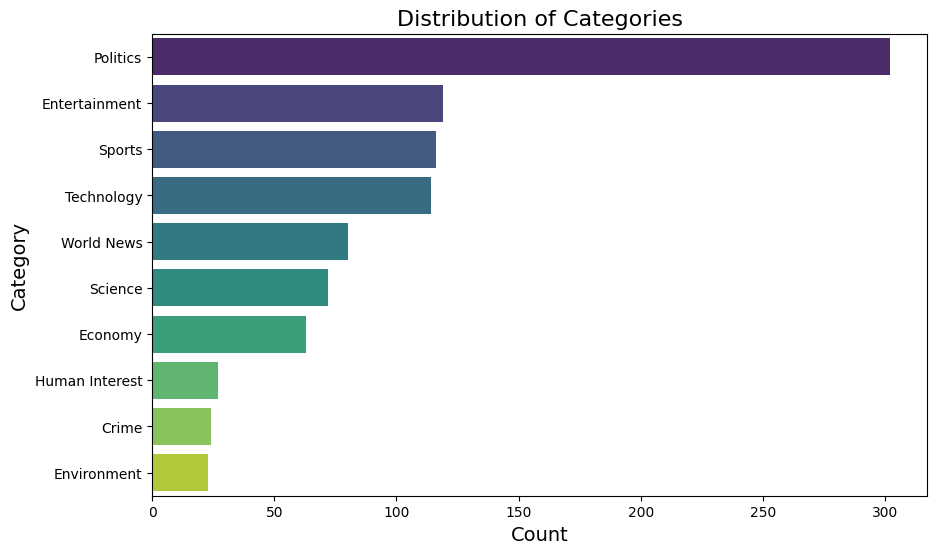

In [100]:
plt.figure(figsize=(10, 6))
seaborn.barplot(
    data=category_table,
    x='Count',
    y='Category',
    hue='Category', 
    palette='viridis'
)
plt.title('Distribution of Categories', fontsize=16)
plt.xlabel('Count', fontsize=14)
plt.ylabel('Category', fontsize=14)
plt.show()

In [101]:
encoder = preprocessing.LabelEncoder()

cleaned_dataset.loc[:, "Category"] = encoder.fit_transform(cleaned_dataset["Category"])

cleaned_dataset.sample(10)

,Title,URL,Source,Journalist(s),Published Date,Content,Category,Label
11,'I have terminal cancer and lost my life savin...,https://www.bbc.com/news/articles/cx2r7enl3d1o,BBC,Carla Basu,27/03/2025,Victims have been conned out of millions of po...,4,1
86,Trump administration reportedly considers a US...,https://techcrunch.com/2025/04/16/trump-admini...,TechCrunch,NaN,16/04/2025,Posted:\n\nThe Trump administration is conside...,8,1
96,German media censor-out even more of the truth...,https://www.theinteldrop.org/2025/04/06/german...,The Intel Drop,Eric Zuesse,06/04/2025,"5 April 2025, byEric Zuesse. (All of my recent...",5,0
53,Trump: Prosecution Of French Opposition Leader...,https://thepeoplesvoice.tv/trump-prosecution-o...,The People's Voice,Niamh Harris,01/04/2025,The US president has said the prosecution of t...,5,0
96,Revelations From Pope Francis’s New Memoir,https://theonion.com/revelations-from-pope-fra...,The Onion,NaN,20/01/2025,"Pope Francis has published his memoir,Hope, ma...",9,0
23,Venezuela to resume repatriation of migrants a...,https://www.bbc.com/news/articles/c17q170zwjeo,BBC,Kayla Epstein,22/03/2025,Venezuela will resume flights for its national...,5,1
54,Jeff Bezos Sends Note To Whole Foods Staff For...,https://theonion.com/jeff-bezos-sends-note-to-...,The Onion,NaN,27/02/2025,MIAMI—Asserting that many differing perspectiv...,1,0
77,âElon Musk Plans to Buy Facebook After Janua...,https://spacexmania.com/elon-musk-plans-to-buy...,SpaceXMania,Alex Bruno,14/12/2024,"In a surprising turn of events, tech mogul Elo...",5,0
178,"30 years after discovery of remains, DNA could...",https://apnews.com/newsletter/ground-game/apri...,AP News,Rick Callahan,07/01/2025,"WESTFIELD, Ind. (AP) â Decades after investi...",6,1
17,Five key moments in the battle for Khartoum,https://www.bbc.com/news/articles/ckgy341v680o,BBC,Peter Mwai,22/03/2025,The Sudanese army has regained control of key ...,5,1


### Journalist(s) conversion 🔁

Let's also categorize the articles based on the presence of an author. First, I want to analyze how frequently each journalist appears in the dataset.

In [102]:
print(cleaned_dataset['Journalist(s)'].value_counts())

Journalist(s)
Alex Bruno                       149
Niamh Harris                      43
Baxter Dmitry                     31
Sean Adl-Tabatabai                24
Kyle Wiggers                      14
                                ... 
Ng Han Guan                        1
Sean O'Kane                        1
Tage Kene-Okafor                   1
Mike Butcher                       1
Lorenzo Franceschi-Bicchierai      1
Name: count, Length: 323, dtype: int64


In [103]:
cleaned_dataset['Journalist(s)'] = cleaned_dataset['Journalist(s)'].notnull().astype(int)

print(cleaned_dataset['Journalist(s)'].value_counts())

Journalist(s)
1    727
0    213
Name: count, dtype: int64


News articles are categorized based on whether they include listed journalists (1) or do not include them (0).

In [106]:
aggregated_data = cleaned_dataset.groupby(['Journalist(s)', 'Label']).size().reset_index(name='Counts')

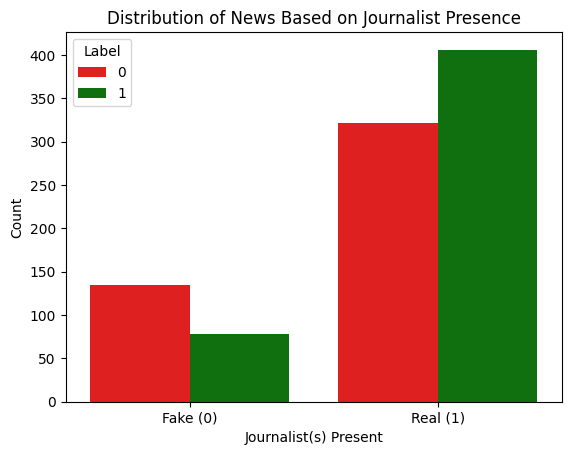

In [107]:
seaborn.barplot(
    data=aggregated_data,
    x='Journalist(s)',
    y='Counts',
    hue='Label',
    palette={0: 'red', 1: 'green'}
)
plt.title('Distribution of News Based on Journalist Presence')
plt.xlabel('Journalist(s) Present')
plt.ylabel('Count')
plt.xticks(ticks=[0, 1], labels=['Fake (0)', 'Real (1)'])
plt.show()

As assumed, journalists' presence is strongly linked to "Real" news, while their absence is more often associated with "Fake" news.

### Stopwords 🛑
Stopwords are the most frequently used words in a language - such as "in", "on", "a", "an" and "the" in English. These words usually carry little meaningful information when analyzing text. Since they do not contribute much to distinguishing between "Fake" and "Real" articles, it is common practice to remove them during preprocessing. Before we do that, let's take a look at some of the stopwords and then proceed to remove them from the dataset.

In [108]:
stemmer = PorterStemmer()

stop_words = set(stopwords.words('English'))

print(stopwords.words('English'))

['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an', 'and', 'any', 'are', 'aren', "aren't", 'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', 'can', 'couldn', "couldn't", 'd', 'did', 'didn', "didn't", 'do', 'does', 'doesn', "doesn't", 'doing', 'don', "don't", 'down', 'during', 'each', 'few', 'for', 'from', 'further', 'had', 'hadn', "hadn't", 'has', 'hasn', "hasn't", 'have', 'haven', "haven't", 'having', 'he', "he'd", "he'll", 'her', 'here', 'hers', 'herself', "he's", 'him', 'himself', 'his', 'how', 'i', "i'd", 'if', "i'll", "i'm", 'in', 'into', 'is', 'isn', "isn't", 'it', "it'd", "it'll", "it's", 'its', 'itself', "i've", 'just', 'll', 'm', 'ma', 'me', 'mightn', "mightn't", 'more', 'most', 'mustn', "mustn't", 'my', 'myself', 'needn', "needn't", 'no', 'nor', 'not', 'now', 'o', 'of', 'off', 'on', 'once', 'only', 'or', 'other', 'our', 'ours', 'ourselves', 'out', 'over', 'own', 're', 's', 'same', 'shan', "shan't", 'she

### Stemming 🌱

Stemming is a text preprocessing technique that helps machine learning algorithms work more efficiently by reducing words to their root form. This process removes suffixes so that related words are treated as the same term. For example, words like "programming", "programmer" and "programs" can all be simplified to their common base: "program". This helps reduce vocabulary size and ensures that the model focuses on the core meaning of words rather than their variations.

In [109]:
stemmer = PorterStemmer()

stop_words = set(stopwords.words('English'))

def preprocess_and_stem(text):
    # tokenize the text, convert to lowercase and remove punctuation
    tokens = word_tokenize(text.lower())
    # remove stopwords and apply stemming
    stemmed_tokens = [stemmer.stem(word) for word in tokens if word.isalnum() and word not in stop_words]

    return ' '.join(stemmed_tokens)

In [110]:
cleaned_dataset['Title'] = cleaned_dataset['Title'].astype(str).apply(preprocess_and_stem)
cleaned_dataset['Content'] = cleaned_dataset['Content'].astype(str).apply(preprocess_and_stem)

print(cleaned_dataset[['Title', 'Content']].head())

                                               Title  \
0     istanbul mayor arrest ahead select run erdogan   
1    kill gaza sinc israel offens began ministri say   
2              ferrari hamilton disqualifi chines gp   
3            life spent wait search row unclaim bodi   
5  us hope progress peac talk three kill russian ...   

                                             Content  
0  main rival turkey presid recep tayyip erdogan ...  
1  palestinian kill israel militari campaign gaza...  
2  lewi hamilton finish sixth chines grand prix s...  
3  saira baloch 15 step morgu first time heard ro...  
5  imogen jamesl report upcom peac talk ukrain wa...  


After removing stopwords and applying stemming, the text has been simplified to its most essential components. Common filler words have been eliminated and variations of the same word have been reduced to a shared root form. This preprocessing step helps reduce the complexity of the dataset, making it easier for the algorithm to focus on meaningful patterns and improving overall model efficiency. As seen in the example above, the text may look less natural, but it is now more suitable for machine learning tasks.

### Word Cloud ☁️
Let's visualize the most frequently used words in both fake and real news, focusing on the "Title" and "Content" columns. Word clouds are an effective and intuitive way to gain a quick understanding of the most used terms in a large body of text. By representing word frequency visually - where more common words appear larger - word clouds help reveal underlying themes or biases in the language used.

We analyze both the title and the content because they serve different but complementary roles in news articles. Titles are often designed to capture attention and may contain emotionally charged or misleading language in fake news. The content, on the other hand, gives deeper context and can expose how each type of article develops its narrative. Comparing word usage in both areas helps us identify linguistic patterns that distinguish real news from fake, which can be valuable features for model training.

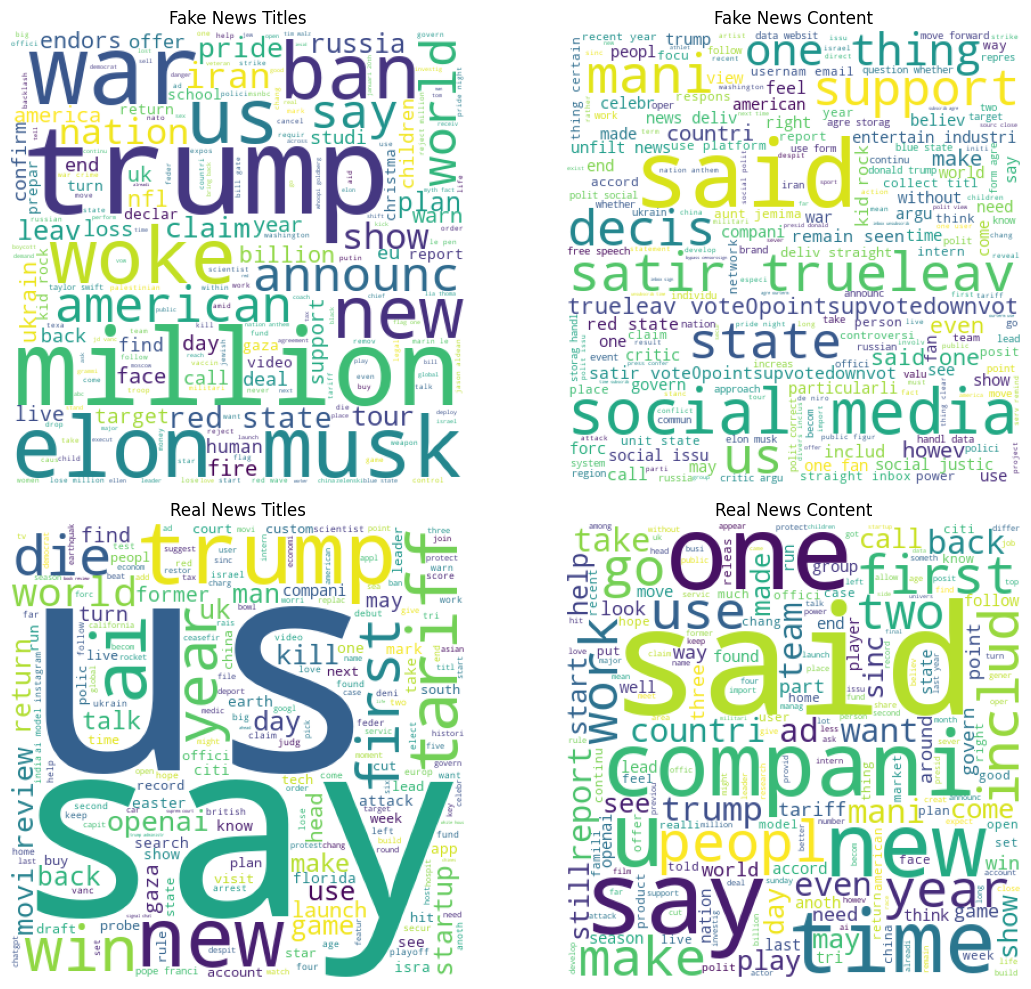

In [111]:
real_titles = ' '.join(cleaned_dataset[cleaned_dataset['Label'] == 1]['Title'])
fake_titles = ' '.join(cleaned_dataset[cleaned_dataset['Label'] == 0]['Title'])

real_content = ' '.join(cleaned_dataset[cleaned_dataset['Label'] == 1]['Content'])
fake_content = ' '.join(cleaned_dataset[cleaned_dataset['Label'] == 0]['Content'])

fig, ax = plt.subplots(2, 2, figsize=(12, 10))

# titles comparison
ax[0, 0].imshow(WordCloud(width=400, height=400, background_color='white').generate(fake_titles))
ax[0, 0].set_title("Fake News Titles")
ax[0, 0].axis('off')

ax[1, 0].imshow(WordCloud(width=400, height=400, background_color='white').generate(real_titles))
ax[1, 0].set_title("Real News Titles")
ax[1, 0].axis('off')

# content comparison
ax[1, 1].imshow(WordCloud(width=400, height=400, background_color='white').generate(real_content))
ax[1, 1].set_title("Real News Content")
ax[1, 1].axis('off')

ax[0, 1].imshow(WordCloud(width=400, height=400, background_color='white').generate(fake_content))
ax[0, 1].set_title("Fake News Content")
ax[0, 1].axis('off')

plt.tight_layout()
plt.show()

To summarize the word clouds:

| **News**   | **Titles**                                                                                          | **Content**                                                                                          |
|-----------------|----------------------------------------------------------------------------------------------------|------------------------------------------------------------------------------------------------------|
| **Fake**   | Big, dramatic words like "million", "war" and "woke" and names of famous people like "Trump", "Elon" and "Musk". | Focus on opinions, social media and words like "support", "satire" and "true". Less about facts, more about feelings or controversy. |
| **Real**   | Words about real events and places like "kill", "win", "Gaza", "Ukraine", "tariff" and "Trump". More factual and direct. | Focus on people, facts and explanations. Common words are "one", "people", "say", "year" and "country." More neutral and informative. |


### Converting the textual data to numerical data 🔁

TF-IDF (Term Frequency-Inverse Document Frequency) is used to convert textual data into numerical features, allowing machine learning models to process it. It assigns weights to words based on their frequency in a document and their rarity across the dataset, highlighting important terms. The `TfidfVectorizer` transforms the cleaned text data into a numerical array, which is used as the input features (X). The target labels (y), already numerical, represent the classification of each text as "Real" (1) or "Fake" (0).

In [ ]:
vectorizer_title = TfidfVectorizer
vectorizer_content = TfidfVectorizer

X_title = vectorizer_title.fit_transform(cleaned_dataset['Title'])
X_content = vectorizer_content.fit_transform(cleaned_dataset['Content'])

print("Title TF-IDF shape:", X_title.shape)
print("Content TF-IDF shape:", X_content.shape)

Title TF-IDF shape: (940, 3000)
Content TF-IDF shape: (940, 15000)


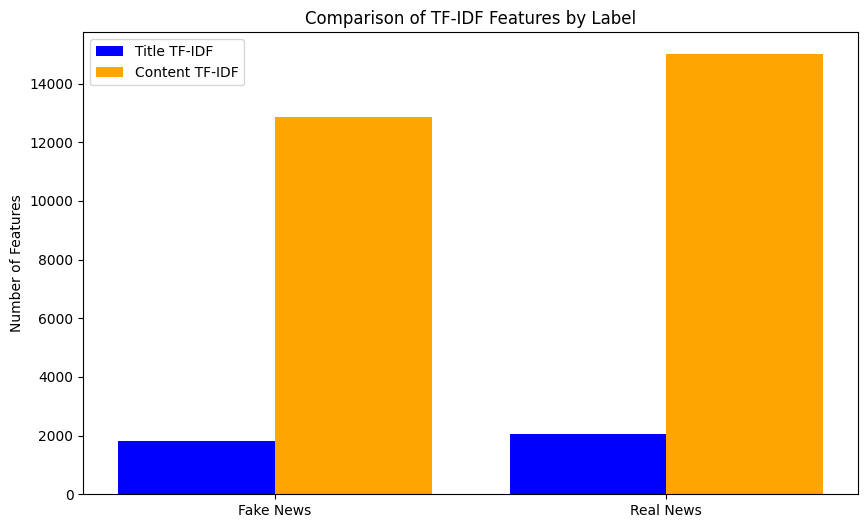

In [249]:
# split by label
fake_titles = cleaned_dataset[cleaned_dataset['Label'] == 0]['Title']
real_titles = cleaned_dataset[cleaned_dataset['Label'] == 1]['Title']

fake_contents = cleaned_dataset[cleaned_dataset['Label'] == 0]['Content']
real_contents = cleaned_dataset[cleaned_dataset['Label'] == 1]['Content']

# transform separately for fake and real data
fake_title_tfidf = vectorizer_title.fit_transform(fake_titles).shape[1]
real_title_tfidf = vectorizer_title.fit_transform(real_titles).shape[1]

fake_content_tfidf = vectorizer_content.fit_transform(fake_contents).shape[1]
real_content_tfidf = vectorizer_content.fit_transform(real_contents).shape[1]

# bar plot
labels = ['Fake News', 'Real News']
title_features = [fake_title_tfidf, real_title_tfidf]
content_features = [fake_content_tfidf, real_content_tfidf]

x = range(len(labels))

plt.figure(figsize=(10, 6))

# title features
plt.bar(x, title_features, width=0.4, label='Title TF-IDF', color='blue', align='center')
# content features
plt.bar([p + 0.4 for p in x], content_features, width=0.4, label='Content TF-IDF', color='orange', align='center')

plt.xticks([p + 0.2 for p in x], labels)
plt.title('Comparison of TF-IDF Features by Label')
plt.ylabel('Number of Features')
plt.legend()
plt.show()


| **Label**   | **Title TF-IDF Features**                                                                                          | **Content TF-IDF Features**                                                                                          |
|-----------------|----------------------------------------------------------------------------------------------------|------------------------------------------------------------------------------------------------------|
| **Fake**   | ~1,900 | ~13,000 |
| **Real**   | ~2,000 | ~17,000 |

- **Content Richness:** Real News articles tend to be longer and more detailed, resulting in a greater diversity of terms and consequently, more TF-IDF features. Fake News articles, by contrast, may be shorter or use a more limited vocabulary.
- **Title Brevity:** Titles, regardless of label, yield far fewer features due to the imited word count.

### Combine the features 🥣
Combine the title and content into one feature matrix.

In [213]:
X = numpy.hstack((X_title, X_content))

### Target variable 🎯 
The target variable is obviously `Label`.

In [214]:
y = cleaned_dataset['Label']

### Splitting into train/test 🪓

We will use 80% of the data for training and the rest - 20% for testing.

In [215]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("There are in total", len(y), "observations, of which", len(X_train), "are now in the train set and", len(X_test), "in the test set.")

There are in total 940 observations, of which 752 are now in the train set and 188 in the test set.


### Modelling 🧬
The test set will be used to calculate the model's accuracy, which indicates how well it performs. 

#### 1. K-Nearest Neighbors (KNN) - Iteration 0
**Pros:**
- Simple and intuitive.
- No training phase, just memorizes the data.

**Cons:**
- Computationally expensive for predictions as it involves searching through the dataset.
- Sensitive to feature scaling and noise.

In [216]:
clf_knn = KNeighborsClassifier(n_neighbors=5)
clf_knn.fit(X_train, y_train)
y_pred_knn = clf_knn.predict(X_test)

In [217]:
print(f"Accuracy of KNN: {accuracy_score(y_test, y_pred_knn) * 100:.2f}%")

Accuracy of KNN: 82.98%


Although KNN is a simple algorithm suitable for the initial phase, the accuracy is acceptable - even though the lowest.

#### 2. Naive Bayes - Iteration 1
**Pros:**
- Efficient for text classification tasks.
- Works well with small datasets.
- Robust in scenarios where the conditional independence assumption is mostly true.

**Cons:**
- Performs poorly if feature independence is not realistic.
- May struggle with imbalanced datasets.

In [218]:
clf_nb = MultinomialNB()
clf_nb.fit(X_train, y_train)
y_pred_nb = clf_nb.predict(X_test)

In [219]:
print(f"Accuracy of Naive Bayes: {accuracy_score(y_test, y_pred_nb) * 100:.2f}%")

Accuracy of Naive Bayes: 90.43%


#### 3. Support Vector Machine (SVM) - Iteration 3
**Pros:**
- Excellent for text classification and high-dimensional spaces.
- Works well with a clear margin of separation.

**Cons:**
- Slower and computationally expensive for large datasets.
- Sensitive to hyperparameters like kernel.

In [220]:
clf_svm = SVC(kernel='linear')
clf_svm.fit(X_train, y_train)
y_pred_svm = clf_svm.predict(X_test)

In [221]:
print(f"Accuracy of SVM: {accuracy_score(y_test, y_pred_svm) * 100:.2f}%")

Accuracy of SVM: 93.62%


Surprisingly, SVM is performing better than Naive Bayes, achieving higher accuracy and the higest accuracy so far of all models.

#### 4. Random Forest - Iteration 3
**Pros:**
- Combines multiple decision trees to reduce overfitting.
- Robust to missing data and scalable.

**Cons:**
- Slower on large datasets.
- May overfit with too many trees or without proper hyperparameter tuning.

In [222]:
clf_rf = RandomForestClassifier(n_estimators=100, random_state=42)
clf_rf.fit(X_train, y_train)
y_pred_rf = clf_rf.predict(X_test)

In [223]:
print(f"Accuracy of Random Forest: {accuracy_score(y_test, y_pred_rf) * 100:.2f}%")

Accuracy of Random Forest: 92.02%


#### 5. Logistic Regression - Iteration 3
**Pros:**
- Easy to implement and interpret.
- Suitable for binary classification problems.

**Cons:**
- May struggle with non-linear separable data.
- Requires good feature engineering.

In [224]:
clf_lr = LogisticRegression(random_state=42)
clf_lr.fit(X_train, y_train)
y_pred_lr = clf_lr.predict(X_test)

In [225]:
print(f"Accuracy of Logistic Regression: {accuracy_score(y_test, y_pred_lr) * 100:.2f}%")

Accuracy of Logistic Regression: 88.83%


#### 6. Stacking - Iteration 3
**Pros:**
- Stacking combines the strengths of all base models, improving predictive performance.
- Different models compensate for each other's weaknesses.
- Easy to try different combinations of base and meta-models.

**Cons:**
- Training multiple models and a meta-model increases computation time.
- If base models are highly complex, the stacking model might overfit.
- The combined predictions make it harder to interpret results compared to a single model.

Since SVM is the model with the highest accuracy, that would be the meta model.

In [251]:
base_models_for_svm = [
    ('knn', KNeighborsClassifier(n_neighbors=5)),   
    ('nb', MultinomialNB()),                       
    ('rf', RandomForestClassifier(n_estimators=100, random_state=42)),
    ('lr', LogisticRegression(random_state=42))
]

meta_model_svm = SVC(kernel='linear', probability=True)
stacking_clf_svm = StackingClassifier(estimators=base_models_for_svm, final_estimator=meta_model_svm, cv=5)

stacking_clf_svm.fit(X_train, y_train)
y_pred_stack_svm = stacking_clf_svm.predict(X_test)

print(f"Accuracy with SVM as Meta-Model: {accuracy_score(y_test, y_pred_stack_svm) * 100:.2f}%")

Accuracy with SVM as Meta-Model: 94.68%


#### 7. Boosting (AdaBoost) - Iteration 3
**Pros:**
- Improves weak learners by combining them into a strong model.
- It handles noisy data by focusing on hard-to-classify instances.
- No need for feature scaling.
- Versatile and works well with simple models.

**Cons:**
- Sensitive to noisy data and outliers.
- Can overfit if too many estimators are used.
- Performance drops with complex base models like SVM or Naive Bayes.
- Computationally expensive for large datasets.

In [227]:
adaboost_nb = AdaBoostClassifier(
    estimator=MultinomialNB(), 
    n_estimators=50, 
    random_state=42
)

adaboost_nb.fit(X_train, y_train)
y_pred_adaboost_nb = adaboost_nb.predict(X_test)

print(f"Accuracy of AdaBoost with Naive Bayes: {accuracy_score(y_test, y_pred_adaboost_nb) * 100:.2f}%")

Accuracy of AdaBoost with Naive Bayes: 89.89%


While the percentage is lower than before boosting, it was expected given the complexity of the models. At least the process was quick.

In [228]:
adaboost_svm = AdaBoostClassifier(
    estimator=SVC(kernel='linear', probability=True, random_state=42), 
    n_estimators=50, 
    random_state=42
)

adaboost_svm.fit(X_train, y_train)
y_pred_adaboost_svm = adaboost_svm.predict(X_test)

print(f"Accuracy of AdaBoost with SVM: {accuracy_score(y_test, y_pred_adaboost_svm) * 100:.2f}%")

Accuracy of AdaBoost with SVM: 43.09%


It took too long -13 minutes - and the percentage is low.

In [229]:
print("All models' accuracies:")
print(f"- KNN: {accuracy_score(y_test, y_pred_knn) * 100:.2f}%")
print(f"- Naive Bayes: {accuracy_score(y_test, y_pred_nb) * 100:.2f}%")
print(f"- SVM: {accuracy_score(y_test, y_pred_svm) * 100:.2f}%")
print(f"- Random Forest: {accuracy_score(y_test, y_pred_rf) * 100:.2f}%")
print(f"- Logistic Regression: {accuracy_score(y_test, y_pred_lr) * 100:.2f}%")
print(f"- Stacking Classifier with SVM as Meta-Model: {accuracy_score(y_test, y_pred_stack_svm) * 100:.2f}%")
print(f"- AdaBoost with Naive Bayes: {accuracy_score(y_test, y_pred_adaboost_nb) * 100:.2f}%")
print(f"- AdaBoost with SVM: {accuracy_score(y_test, y_pred_adaboost_svm) * 100:.2f}%")

All models' accuracies:
- KNN: 82.98%
- Naive Bayes: 90.43%
- SVM: 93.62%
- Random Forest: 92.02%
- Logistic Regression: 88.83%
- Stacking Classifier with SVM as Meta-Model: 94.68%
- AdaBoost with Naive Bayes: 89.89%
- AdaBoost with SVM: 43.09%


To sum up, the SVM (93.62%) and the Stacking Classifier with SVM as the meta-model achieved the highest accuracy (94.68%). 

SVMs are particularly effective for high-dimensional datasets like text, as they can capture complex, non-linear relationships and are robust to overfitting when properly regularized. The Stacking Classifier further improves performance by combining the strengths of multiple base models and leveraging SVM’s decision-making power at the meta-level.

Random Forest also performed strongly (92.02%), benefiting from its ability to handle noisy data and identify important features, which is valuable in text classification where many irrelevant or redundant features may exist. Naive Bayes (90.43%) and Logistic Regression (88.83%) performed well too, largely because text data often fits the assumptions of these models-word frequencies and linear separability can be strong signals in distinguishing fake from truthful news.

KNN lagged behind (83.98%) because it struggles with high-dimensional feature spaces typical in text data, where the distance metrics become less meaningful. AdaBoost with Naive Bayes (89.89%) performed reasonably. AdaBoost with SVM, however, performed extremely poorly (43.09%), likely because SVMs are already strong learners and boosting them can lead to overfitting or instability.

Overall, the results show that models capable of handling high-dimensional, sparse and noisy data (like SVM and Random Forest) excel in fake news detection, while simpler models or those less suited to text data (like KNN or poorly configured ensemble methods) underperform.

## Evaluation 🔬

This report evaluates the accuracy of recognising news as fake or real and assesses the model's performance.

It is preferable to have fewer instances of "fake" news classified as truthful, as the opposite scenario is less detrimental. Classifying fake news as truthful (false positives) is harmful because it can spread misinformation, erode trust and amplify harmful content. On the other hand, mistakenly flagging truthful news as fake is less damaging since it encourages caution and further verification.

In [230]:
# 1. K-Nearest Neighbors (KNN)
print(classification_report(y_test, y_pred_knn))

              precision    recall  f1-score   support

           0       0.88      0.81      0.84       107
           1       0.78      0.85      0.81        81

    accuracy                           0.83       188
   macro avg       0.83      0.83      0.83       188
weighted avg       0.83      0.83      0.83       188



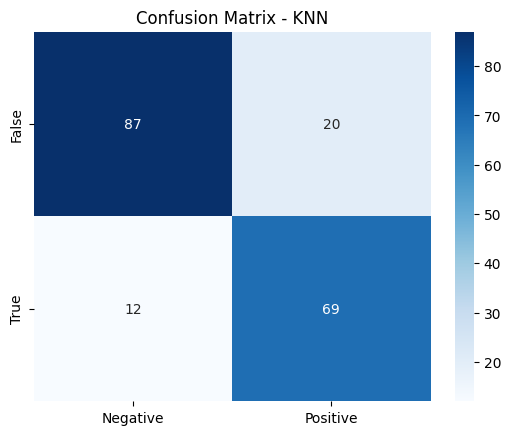

In [231]:
cm = confusion_matrix(y_test, y_pred_knn)

seaborn.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['False', 'True'])
plt.title('Confusion Matrix - KNN')
plt.show()

As the algorithm is pretty simple, when it comes to accuracy is fine. The confusion matrix has a decent balance, but it shows a high number of false positives (20), compared to the true negatives (12).

In [232]:
# 2. Naive Bayes
print(classification_report(y_test, y_pred_nb))

              precision    recall  f1-score   support

           0       0.95      0.88      0.91       107
           1       0.85      0.94      0.89        81

    accuracy                           0.90       188
   macro avg       0.90      0.91      0.90       188
weighted avg       0.91      0.90      0.90       188



 The F1-scores for both classes are close (0.91 vs. 0.89), indicating balanced performance with no severe bias toward either class.

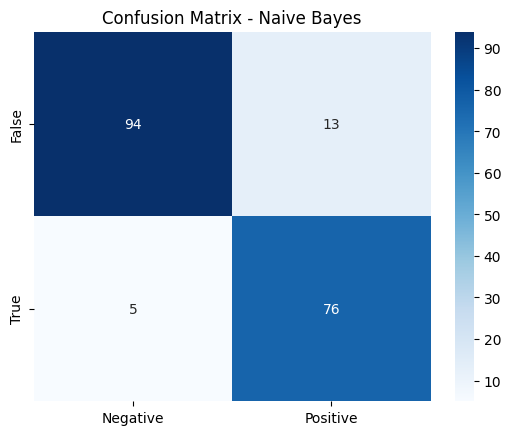

In [233]:
cm = confusion_matrix(y_test, y_pred_nb)

seaborn.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['False', 'True'])
plt.title('Confusion Matrix - Naive Bayes')
plt.show()

With Naive Bayes, the false positives(13) outnumber the true negatives(5), which is not ideal, but much better.

In [234]:
# 3. Support Vector Machine (SVM)
print(classification_report(y_test, y_pred_svm))

              precision    recall  f1-score   support

           0       0.97      0.92      0.94       107
           1       0.90      0.96      0.93        81

    accuracy                           0.94       188
   macro avg       0.93      0.94      0.94       188
weighted avg       0.94      0.94      0.94       188



High across the board (F1: 0.94/0.93).

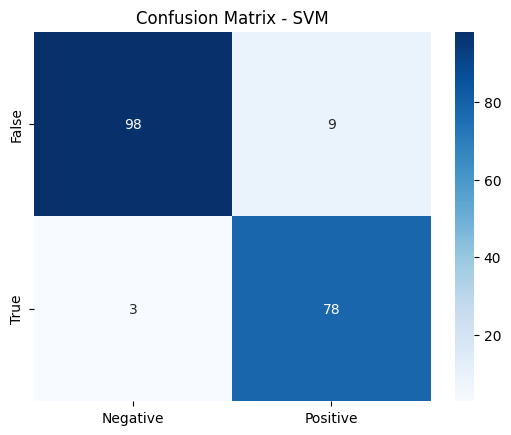

In [235]:
cm = confusion_matrix(y_test, y_pred_svm)

seaborn.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['False', 'True'])
plt.title('Confusion Matrix - SVM')
plt.show()

Surprisingly, SVM is performing better than Naive Bayes, not only achieving higher accuracy, but a better F1 score and lower false positives(9) and true negatives(3). 

In conclusion, SVM is robust for text classification, minimizing harmful errors (fake news as real) better than simpler models.

In [236]:
# 4. Random Forest
print(classification_report(y_test, y_pred_rf))

              precision    recall  f1-score   support

           0       1.00      0.86      0.92       107
           1       0.84      1.00      0.92        81

    accuracy                           0.92       188
   macro avg       0.92      0.93      0.92       188
weighted avg       0.93      0.92      0.92       188



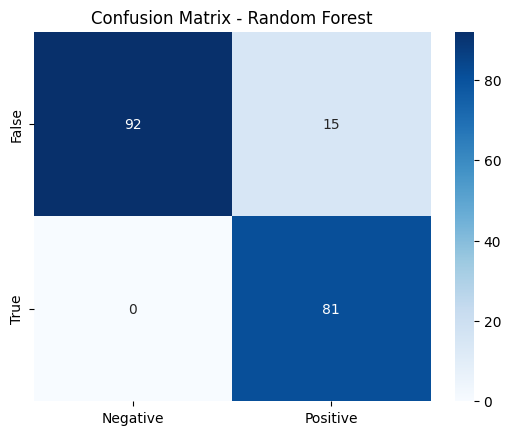

In [237]:
cm = confusion_matrix(y_test, y_pred_rf)

seaborn.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['False', 'True'])
plt.title('Confusion Matrix - Random Forest')
plt.show()

Interestingly, there are no true negatives. The percentage is high, but not higher than SVM. Random Forest is powerful, but in this case, still allows a concerning number of fake news items to be labeled as truthful.

In [238]:
# 5. Logistic Regression
print(classification_report(y_test, y_pred_lr))

              precision    recall  f1-score   support

           0       0.99      0.81      0.89       107
           1       0.80      0.99      0.88        81

    accuracy                           0.89       188
   macro avg       0.89      0.90      0.89       188
weighted avg       0.91      0.89      0.89       188



Slightly lower than SVM/RF, F1: 0.89/0.88.

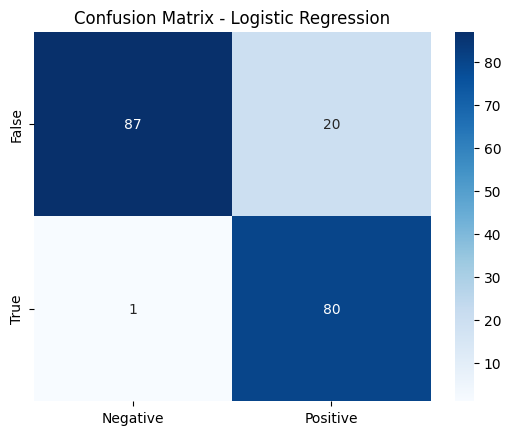

In [239]:
cm = confusion_matrix(y_test, y_pred_lr)

seaborn.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['False', 'True'])
plt.title('Confusion Matrix - Logistic Regression')
plt.show()

We are still facing the same issue: there is a significant number of false positives(20), which exceeds the true negatives(1). 

In conclusion, like KNN, Logistic Regression is challenged by the complexity of text data, leading to risky misclassifications.

In [240]:
# 6. Stacking Classifier with SVM as Meta-Model
print(classification_report(y_test, y_pred_stack_svm))

              precision    recall  f1-score   support

           0       0.96      0.94      0.95       107
           1       0.93      0.95      0.94        81

    accuracy                           0.95       188
   macro avg       0.94      0.95      0.95       188
weighted avg       0.95      0.95      0.95       188



Very strong, F1: 0.94/0.93.

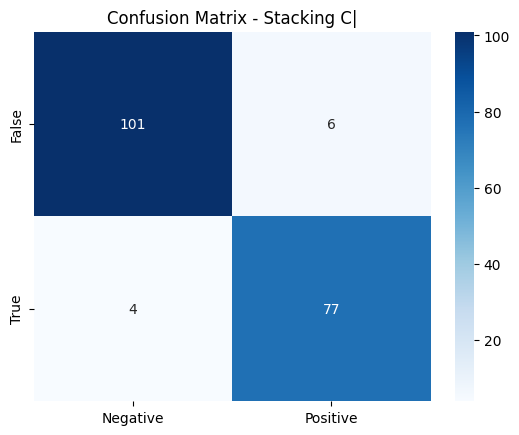

In [241]:
cm_svm = confusion_matrix(y_test, y_pred_stack_svm)

seaborn.heatmap(cm_svm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['False', 'True'])
plt.title('Confusion Matrix - Stacking C|')
plt.show()

Best so far, with only 6 false positives and 4 true negatives. 

Stacking leverages multiple models’ strengths, reducing the most dangerous error (fake as real) more effectively. 

In [242]:
# 7.1. AdaBoost with Naive Bayes
print(classification_report(y_test, y_pred_adaboost_nb))

              precision    recall  f1-score   support

           0       0.92      0.90      0.91       107
           1       0.87      0.90      0.88        81

    accuracy                           0.90       188
   macro avg       0.90      0.90      0.90       188
weighted avg       0.90      0.90      0.90       188



Balanced but lower than SVM/Stacking.

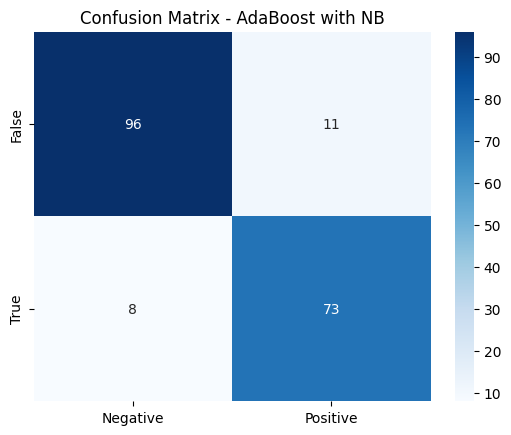

In [243]:
cm_ada_nb = confusion_matrix(y_test, y_pred_adaboost_nb)

seaborn.heatmap(cm_ada_nb, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['False', 'True'])
plt.title('Confusion Matrix - AdaBoost with NB')
plt.show()

Here with the AdaBoost - both false positives and true negatives are almost equal. Boosting helps, but base learner limitations persist. Still a notable number of fake news items misclassified as real.

In [244]:
# 7.2. AdaBoost with SVM
print(classification_report(y_test, y_pred_adaboost_svm))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       107
           1       0.43      1.00      0.60        81

    accuracy                           0.43       188
   macro avg       0.22      0.50      0.30       188
weighted avg       0.19      0.43      0.26       188



c:\Users\ivetk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\ivetk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\ivetk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

Extremely poor for class 0 (fake news as real), with 0 precision/recall.

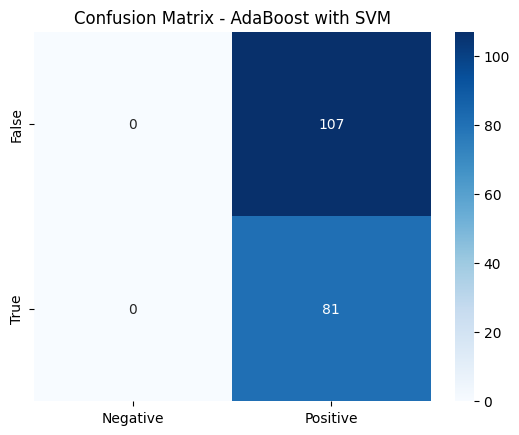

In [245]:
cm_ada_svm = confusion_matrix(y_test, y_pred_adaboost_svm)

seaborn.heatmap(cm_ada_svm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['False', 'True'])
plt.title('Confusion Matrix - AdaBoost with SVM')
plt.show()

107 false positives, 0 true negatives-almost all fake news is misclassified as real. This combination fails completely, likely due to incompatibility between AdaBoost and SVM as a base estimator in this context.

Overall, minimizing False Positives is crucial. In fake news detection, labeling fake news as real (false positives) is the most dangerous error. SVM and especially the Stacking Classifier with SVM meta-model minimize this risk best.

Simpler models (KNN, Logistic Regression) and some ensemble methods (AdaBoost with SVM) are not suitable here due to high false positives.

## Website 🌐

I am taking the best model for the website:

In [252]:
joblib.dump(stacking_clf_svm, 'website/models/stacking_svm.pkl')

['website/models/stacking_svm.pkl']

In [250]:
joblib.dump(vectorizer_title, 'website/models/vectorizer_title.pkl')
joblib.dump(vectorizer_content, 'website/models/vectorizer_content.pkl')

['website/models/vectorizer_content.pkl']